In [1]:
from pathlib import Path
import torch
import numpy as np
import os
import torch.optim as optim

from hubmap.data import DATA_DIR
from checkpoints import CHECKPOINT_DIR
from configs import CONFIG_DIR
from hubmap.models import DUCKNetPretrained
from hubmap.dataset import transforms as T
from torch.utils.data import DataLoader
from hubmap.experiments.DUCKNet.utils import train, DiceLoss
from hubmap.dataset import ValDataset, TrainDataset, TestDataset

c:\Users\gulBa\AppData\Local\pypoetry\Cache\virtualenvs\hubmap-nJ1voaj--py3.11\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_ckpt = torch.load(
    Path(CHECKPOINT_DIR / 'DUCKNet/ducknet_pretrained_focal_256_20.pt'))

model = DUCKNetPretrained(input_channels=3, out_classes=4)

state_dict = model_ckpt['model_state_dict']

#---------------Addition-----------------#
#Run one training loop because otherwise the model is missing some keys
train_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((64, 64)),
    ]
)
val_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((64, 64)),
    ]
)
train_set = TrainDataset(DATA_DIR, transform=train_transforms, with_background=True)
val_set = ValDataset(DATA_DIR, transform=val_transforms, with_background=True)

train_loader = DataLoader(
    train_set, batch_size=32, shuffle=False
)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
train_losses, train_accs = train(
    model, train_loader, 
    optimizer=optim.Adam(model.parameters(), lr=0.001), 
    criterion=DiceLoss(), device=device
)
#---------------END OF Addition-----------------#

Starting DUCK-Net with pretrained resnet18


In [3]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
# Define a function to plot the images and masks
def plot_images(images, masks):
    fig, axs = plt.subplots(len(images), 2, figsize=(5, len(images)*5))
    for i, (img, mask) in enumerate(zip(images, masks)):
        axs[i, 0].imshow(img.permute(1, 2, 0).cpu().numpy())
        axs[i, 1].imshow(torch.argmax(mask, dim=0).cpu().numpy())
    plt.show()

sorting


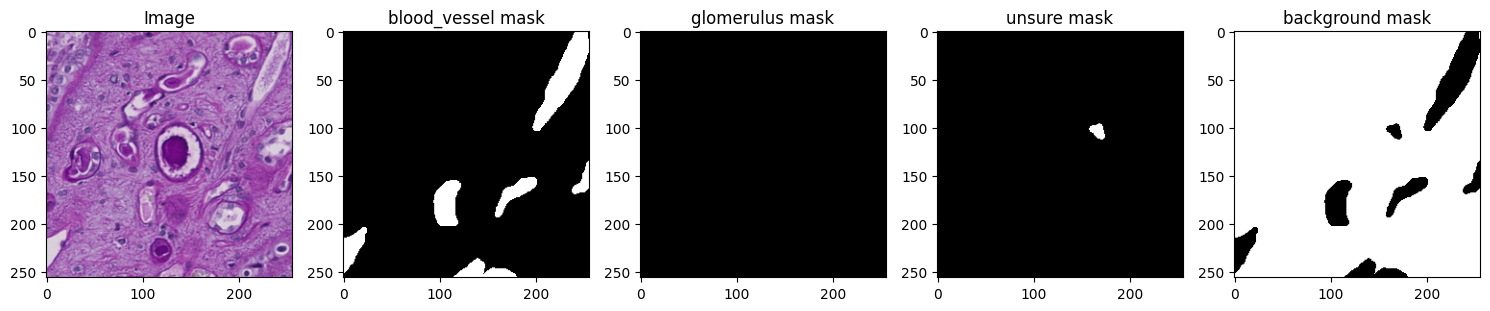

In [4]:
test_transforms = T.Compose(
    [
        T.ToTensor(),
        T.Resize((256, 256)),
    ]
)

test = TestDataset(DATA_DIR, transform=test_transforms, with_background=True)
test.plot_example(133)
model.load_state_dict(state_dict)


# Define the indexes
indexes = [133, 5, 3, 83, 117]
# Place to store images and masks
images = []
predicted_masks = []

In [5]:
# Predict the masks and store them
with torch.no_grad():
    model.eval()
    for idx in indexes:
        # Get the specific image (assuming image is the first element in the tuple)
        image = test[idx][0].unsqueeze(0).to(device) # Add batch dimension

        # Predict the mask
        predicted_mask = model(image)

        # Upscale the image and predicted mask to 512x512
        image = F.interpolate(image, size=(512, 512), mode='bilinear', align_corners=False)
        predicted_mask = F.interpolate(predicted_mask, size=(512, 512), mode='nearest')

        probs = F.sigmoid(predicted_mask)
        classes = torch.argmax(probs, dim=1, keepdims=True)
        classes_per_channel = torch.zeros_like(probs)
        classes_per_channel.scatter_(1, classes, 1)
        classes_per_channel = classes_per_channel.squeeze(0).cpu()
        predicted_masks.append(classes_per_channel)

        # Store the upscaled image and predicted mask
        images.append(image.squeeze(0))
        #predicted_masks.append(predicted_mask.squeeze(0))

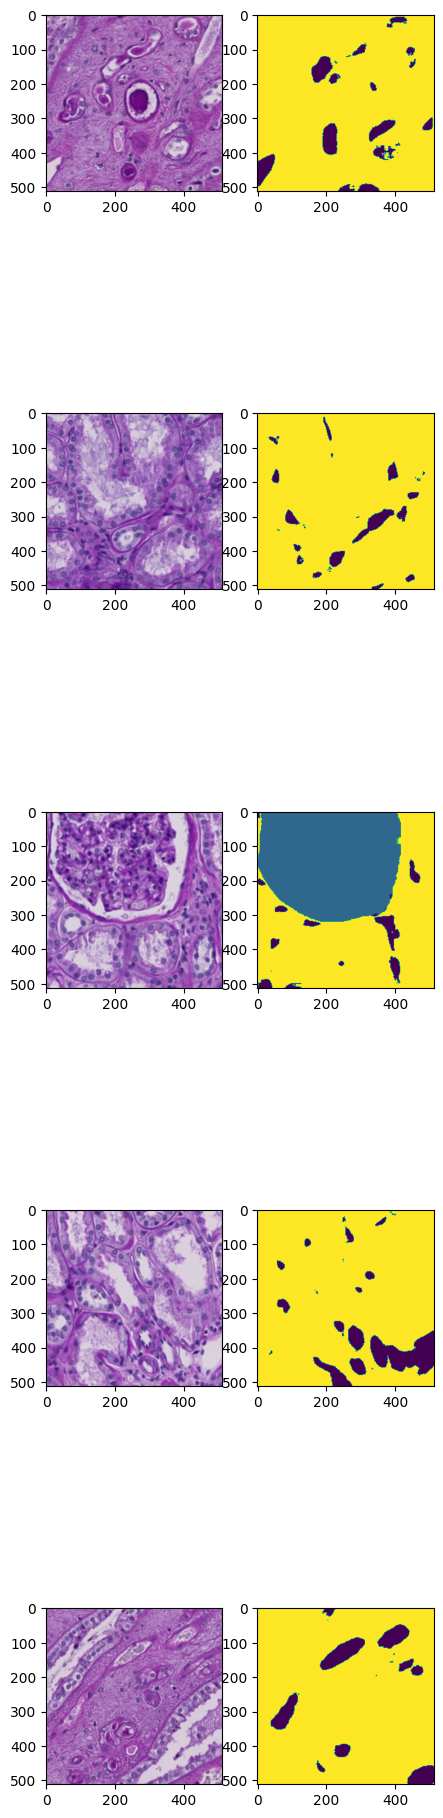

In [6]:
# Plot the images and predicted masks
plot_images(images, predicted_masks)

In [8]:
for i, mask in enumerate(predicted_masks):
    file_name = f'{i}.pt'
    torch.save(mask, file_name)
    print(f"Saved {file_name}")

Saved 0.pt
Saved 1.pt
Saved 2.pt
Saved 3.pt
Saved 4.pt
